# Paper: Automated Detection of Alzheimer’s via Hybrid Classical Quantum Neural Networks by Tayyaba Shahwar, Jinaid Zafar at al.

## Hybrid Quantum Neural Network for Alzheimer's desease detection

Deep Neural Networks have offered numerous innovative solutions to medicine and brain-deseases detection including Alzheimer's. Nevertheless there are goals and problems need to be solved and developed to achive better results. Fortunatly, they can be solved using quatum algorithms in the combination with classical methods.

The authors of the paper offer the following model:
    Classical DL pretrained model ResNet34 acts as feature exctractor: 512-feature vector is fed to a quantum variational circuit. Quantum circuit transforms a 512-feature vector into 4-feature vector to fit it into a fully connected layer that generates the final prediction.


## Dataset
In this work the authors used open source dataset from Kaggle containing 6400 labeled MRI brain images. Dataset is availebel to download from Kaggle: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

Dataset is split into **train** and **test**

All the images are devided into four groups:

    1. Non Demented - desease does not exsists
    2. Mild Demented - first stage
    2. Very Mild Demented - second stage
    3. Moderate Demented - the last stage - most obvious to detect

In the current work to repeat results for a binary clssification I used only two groups: Non Demented and Very Mild Demented



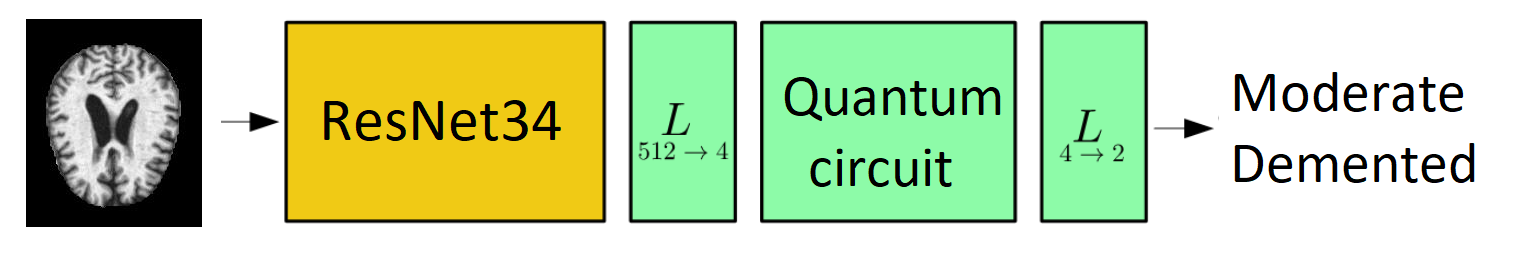

In [1]:
! pip install pennylane 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.7 MB/s eta 0:00:00


In [2]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import os
import copy

env: OMP_NUM_THREADS=1


In [3]:
n_qubits = 4                     # Number of qubits
quantum = True                   # If set to "False", the dressed quantum circuit is replaced by 
                                 # An enterily classical net (defined by the next parameter). 
classical_model = '512_nq_2'     # Possible choices: '512_2','512_nq_2','551_512_2'. 
step = 0.0004                    # Learning rate
batch_size = 8                   # Number of samples for each training step
num_epochs = 1  # 30                 # Number of training epochs
q_depth = 6                      # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1         # Learning rate reduction applied every 10 epochs.                       
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights
rng_seed = 0                     # Seed for random number generator
start_time = time.time()         # Start of the computation timer

In [4]:
resnet_balanced_acc = []
resnet_balanced_loss = []
resnet_nonbalnced_acc = []
resnet_nonbalanced_loss = []

cq_balanced_acc = []
cq_balanced_loss = []
cq_nonbalanced_acc = []
cq_nonbalanced_loss = []

To use quantum semulator we nead to initialize pannylane device. Here I initialize a default qubit device

In [5]:
dev = qml.device('default.qubit', wires=n_qubits)

Connect Cuda to use GPU

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data loading and preprocessing

The PyTorch packages **torchvision** and **torch.utils.data** are used for loading the dataset and performing standard preliminary image operations: resize, center, crop, normalize, etc

In [7]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),     # uncomment for data augmentation
        #transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # Normalize input channels using mean values and standard deviations of ImageNet.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/diploma/Alzheimer_s Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                     data_transforms[x]) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [8]:
dataset_sizes

{'train': 4352, 'val': 1088}

## Data visualization


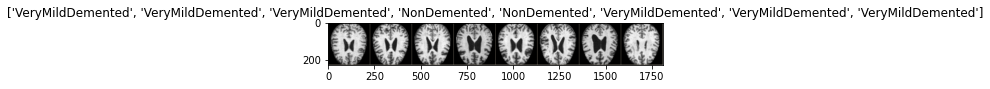

In [9]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In order to get reproducible results, we set a manual seed for the random number generator and re-initialize the dataloaders.

In [10]:
torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size,shuffle=True) for x in ['train', 'val']}

## Classical ResNet34

In [11]:
def train_classic_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = 1.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # if min_loss < epoch_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    # return model
    return best_acc, min_loss

In [12]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [16]:
for step in range(3, 25, 3):
    model_ft = models.resnet34(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, 2)

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    acc, loss = train_classic_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=step)
    resnet_balanced_acc.append(acc)
    resnet_balanced_loss.append(loss)

with open('resnet_balanced_acc.txt', 'w') as file:
    for acc in resnet_balanced_acc:
        file.write(f'{acc},')

with open('resnet_balanced_loss.txt', 'w') as file:
    for loss in resnet_balanced_loss:
        file.write(f'{loss},')

Epoch 0/2
----------
train Loss: 0.6944 Acc: 0.6877
val Loss: 0.6539 Acc: 0.7123

Epoch 1/2
----------
train Loss: 0.3777 Acc: 0.8451
val Loss: 0.7189 Acc: 0.7629

Epoch 2/2
----------
train Loss: 0.2088 Acc: 0.9235
val Loss: 0.4766 Acc: 0.8134

Training complete in 21m 20s
Best val Acc: 0.813419
Epoch 0/5
----------
train Loss: 0.6580 Acc: 0.7102
val Loss: 0.6628 Acc: 0.7463

Epoch 1/5
----------
train Loss: 0.3833 Acc: 0.8392
val Loss: 0.6192 Acc: 0.7454

Epoch 2/5
----------
train Loss: 0.1786 Acc: 0.9343
val Loss: 0.5778 Acc: 0.7858

Epoch 3/5
----------
train Loss: 0.0660 Acc: 0.9770
val Loss: 0.6448 Acc: 0.7960

Epoch 4/5
----------
train Loss: 0.0627 Acc: 0.9766
val Loss: 0.6144 Acc: 0.7996

Epoch 5/5
----------
train Loss: 0.0219 Acc: 0.9929
val Loss: 0.6820 Acc: 0.7877

Training complete in 6m 42s
Best val Acc: 0.799632
Epoch 0/8
----------
train Loss: 0.6971 Acc: 0.6935
val Loss: 0.9001 Acc: 0.6774

Epoch 1/8
----------
train Loss: 0.4160 Acc: 0.8408
val Loss: 0.5240 Acc: 0.7

KeyboardInterrupt: ignored

## Hybrid transfer learning model (Classical to Quantum)

A quantum variational circuit consists of:
1. The state preparation layer
2. Variational layers
3. Measurement layers

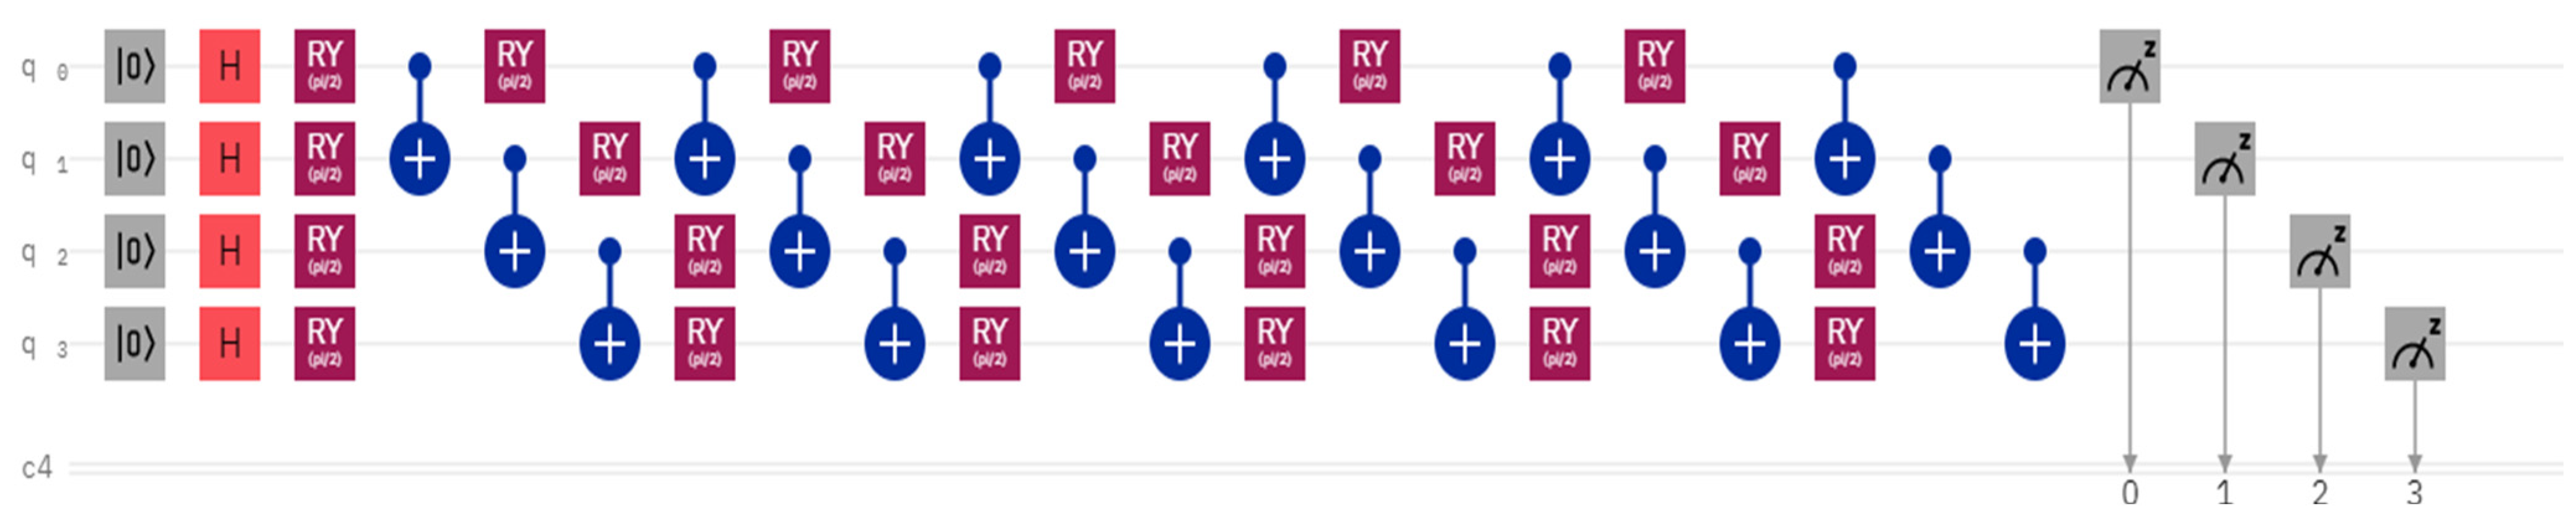

The **state prep** layer processes data in two stages: at first all the qubits are set in the vaccum state $| 0\rangle$ then Hadamard gates convert classical input data into quantum states.

The **variational** layer is a sequense of trainable rotation gates **RY** and constant operators **CNOT** (Controlled Not gates).

The **measurement** layer returns and expectation values measured for 4 qubits.

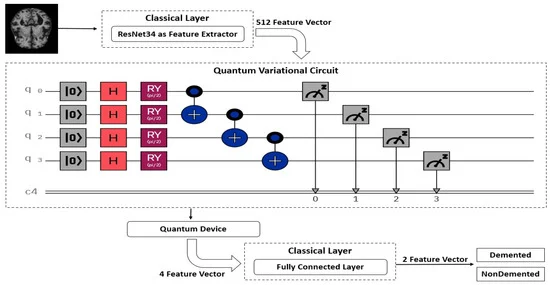

We first define some quantum layers that will compose the quantum circuit.

In [13]:
def H_layer(nqubits):
    """
    Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """
    Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """
    Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    #CNOT---CNOT---CNOT---CNOT...---CNOT---
    # ---CNOT---CNOT---CNOT...---CNOT---  
    for i in range(0, nqubits - 1, 2): #loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2): #loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

We define a quantum ciscuit by using the Pennylane **qnode** decorator.

Structure of the circuit:

1. Qubits are initialized and set in a balansed duperposition of $|0 \rangle$ and $|1⟩$ states via Hadamard gate. 
2. A Sequence of RY and CNOT gates are applied on the data.
3. The local values of the Z operator is measured for each qubit to produce an output vector for additional post-processing.

In [14]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)   
        
        # Embed features in the quantum node
        RY_layer(q_in)      
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k + 1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

We can now define a custom torch.nn.Module representing a dressed quantum circuit.
This is is a concatenation of:

1. A classical pre-processing layer (nn.Linear)
2. A classical activation function (F.tanh)
3. A constant np.pi/2.0 scaling factor.
4. The previously defined quantum circuit (q_net)
5. A classical post-processing layer (nn.Linear)

The input of the module is a batch of vectors with 512 real parameters (features) and the output is a batch of vectors with two real outputs (associated with the two classes of images: Non Demented and Very Mild Demented).

In [15]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, 2)

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            
            # Apply the quantum circuit to each element of the batch and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

We are finally ready to build our full hybrid classical-quantum network. We follow the transfer learning approach:

1. First load the classical pre-trained network ResNet34 from the torchvision.models.
2. Freeze all the weights since they should not be trained.
3. Replace the last fully connected layer with our trainable dressed quantum circuit (Quantumnet). Alternatively, if quantum==False, an entirely classical network is used.

In [16]:
model_hybrid = torchvision.models.resnet34(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False
    
if quantum:
    model_hybrid.fc = Quantumnet()
    
elif classical_model == '512_2':
    model_hybrid.fc = nn.Linear(512, 2)
    
elif classical_model == '512_nq_2':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, 2)) 

elif classical_model == '551_512_2':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, 2))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

## Training and results

Specify the loss function

In [17]:
criterion = nn.CrossEntropyLoss()

Initialize an Adam Optimizer

In [18]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of gamma_lr_scheduler every 4 epochs.

In [19]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=4, gamma=gamma_lr_scheduler)

Now define a train function

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        train_loss = 100000.0
        train_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')

        for epoch in range(num_epochs):    
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    scheduler.step()
                    # Set model to training mode
                    model.train()  
                else:
                    # Set model to evaluate mode
                    model.eval()
                running_loss = 0.0
                running_corrects = 0
                
                # Iterate over data.
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, labels in dataloaders[phase]:
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    
                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1

                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))
                
                # Check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss
        
        # Print final results           
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        # return model
        return best_acc, best_loss, best_acc_train, best_loss_train

In [ ]:
cq_val_acc, cq_val_loss, cq_train_acc, cq_train_loss = [], [], [], []
# model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid,exp_lr_scheduler, num_epochs=num_epochs)
for step in range(9, 20, 3):

    # initialize a model
    model_hybrid = torchvision.models.resnet34(pretrained=True)

    for param in model_hybrid.parameters():
        param.requires_grad = False
        
    if quantum:
        model_hybrid.fc = Quantumnet()
        
    elif classical_model == '512_2':
        model_hybrid.fc = nn.Linear(512, 2)
        
    elif classical_model == '512_nq_2':
        model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, 2)) 

    elif classical_model == '551_512_2':
        model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, 2))

    # Use CUDA or CPU according to the "device" object.
    model_hybrid = model_hybrid.to(device)

    val_acc, val_loss, train_acc, train_loss =  train_model(model_hybrid, criterion, optimizer_hybrid,exp_lr_scheduler, num_epochs=step)
    cq_val_acc.append(val_acc)
    cq_val_loss.append(val_loss)
    cq_train_acc.append(train_acc)
    cq_train_loss.append(train_loss)

with open('cq_val_acc.txt', 'w') as file:
    for acc in cq_val_acc:
        file.write(f'{acc},')

with open('cq_val_loss.txt', 'w') as file:
    for loss in cq_val_loss:
        file.write(f'{loss},')

with open('cq_train_acc.txt', 'w') as file:
    for acc in cq_train_acc:
        file.write(f'{acc},')

with open('cq_train_loss.txt', 'w') as file:
    for loss in cq_train_loss:
        file.write(f'{loss},')

## Saving weights of the best model

In [ ]:
if quantum:
        torch.save(model_hybrid.state_dict(), "quantum_ants_bees.pt")
else:
        torch.save(model_hybrid.state_dict(), "classical_ants_bees.pt")
print("Model state_dict saved.")

Model state_dict saved.


## Load model from file

In [ ]:
if quantum:
    model_hybrid.load_state_dict(torch.load("quantum_ants_bees.pt"))
else:
    model_hybrid.load_state_dict(torch.load("classical_ants_bees.pt"))

In [ ]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['val'] // batch_size
it = 0

# Testing loop
for inputs, labels in dataloaders['val']:
    model_hybrid.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it + 1, n_batches + 1), end='\r', flush=True)
    it+=1
# Print final results                    
epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects / dataset_sizes['val']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))


Test Loss: 0.1055 Test Acc: 0.9816        


## Visualize_model

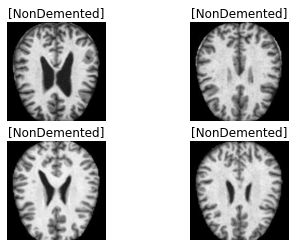

In [ ]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
        
visualize_model(model_hybrid, num_images=batch_size)

# Results and Comparisons 

What I got for classical ResNet34:

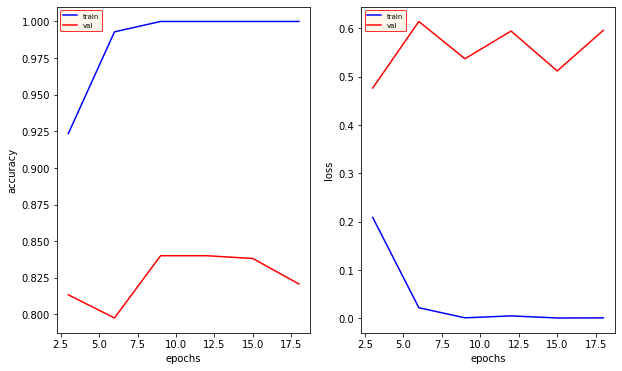

For Classic-Quantum transfer learning model:

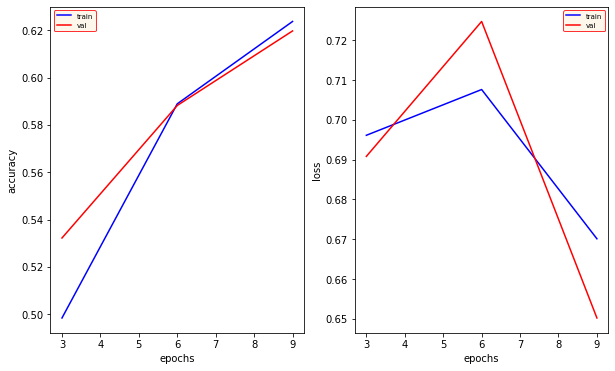

Accuracy plot and loss plot for a Pennylane simulator with ResNet34

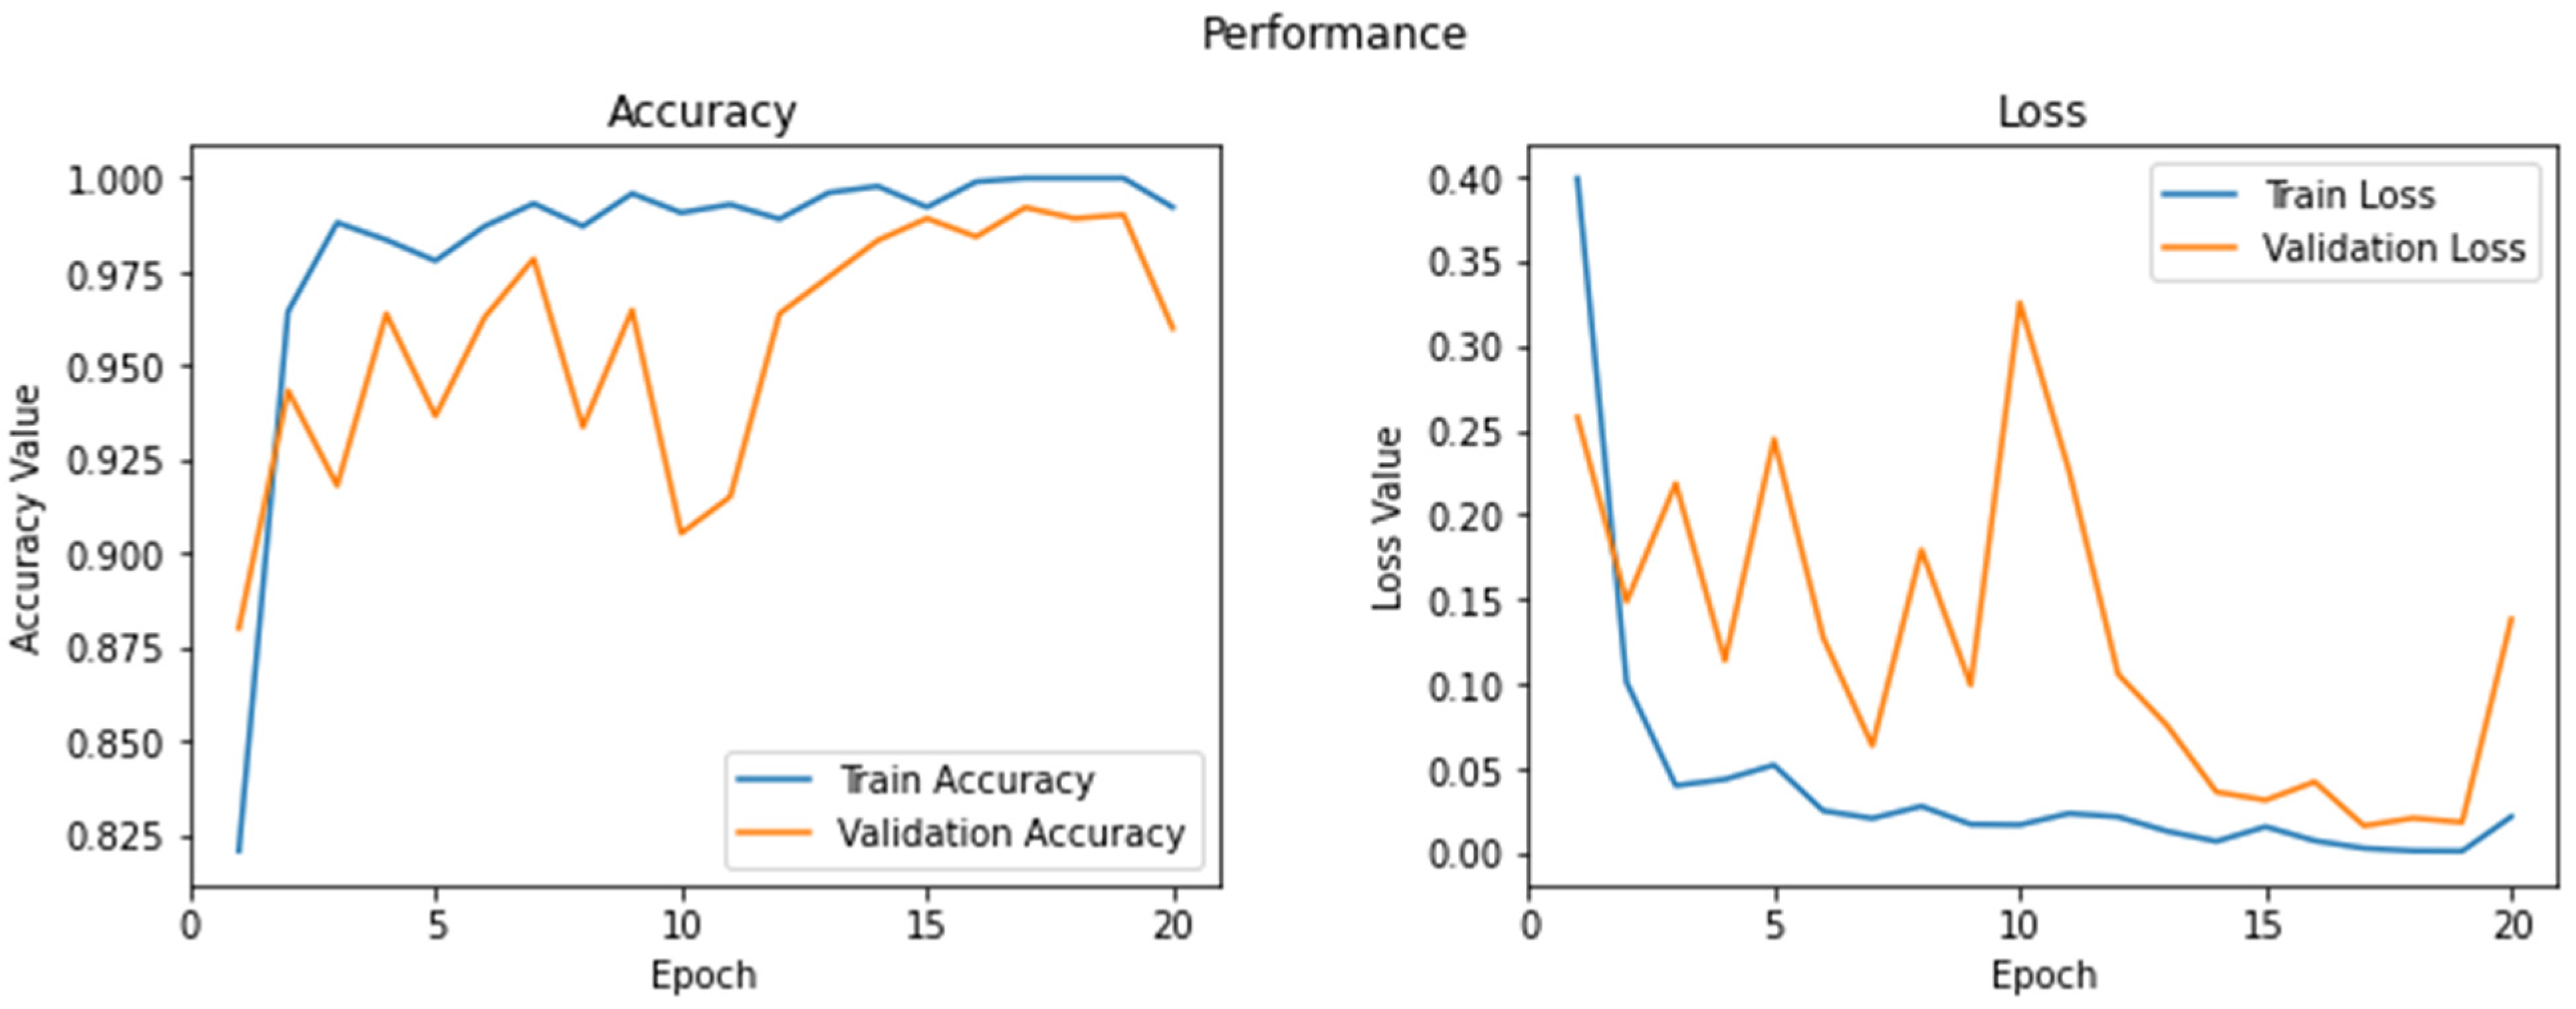

Comparison between classical model and quantum transfer learning model

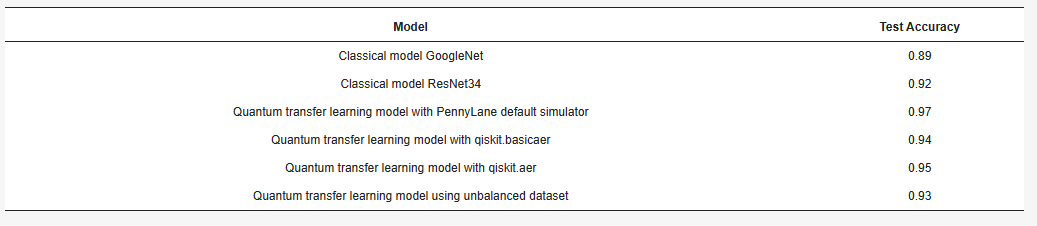

## References:
1. Automated Detection of Alzheimer’s via Hybrid Classical Quantum Neural Networks:  https://www.mdpi.com/2079-9292/11/5/721
2. PyTorch transfer learning tutorial https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
2. Transfer learning in hybrid classical-quantum neural learning  https://quantum-journal.org/papers/q-2020-10-09-340/pdf/
3. Examples https://github.com/XanaduAI/quantum-transfer-learning/blob/master/c2q_transfer_learning_ants_bees.ipynb